# ABIDE subtype normalization
This notebook investigates the influence of different normalization techniques on the subtypes that can be achieved with them.

In [2]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin

/home/surchs/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def get_mask(mask_path):
    """
    Get the mask
    """
    m_img = nib.load(mask_path)
    mask = m_img.get_data()
    mask = mask!=0

    return mask, m_img

In [5]:
def prep_pheno(pheno_path, data_path, map_type, template):
    """
    Remove entries with duplicates or no imaging files
    """
    pheno = pd.read_csv(pheno_path)
    drop_id = list()
    path_list = list()
    pheno = pd.read_csv(pheno_path)
    for index, row in pheno.iterrows():
        s_id = row['SUB_ID']
        s_path = glob.glob(os.path.join(data_path, map_type, template.format(s_id, map_type)))
        if s_path:
            path_list.append(s_path[0])
        else:
            drop_id.append(index)
            continue
    clean_pheno = pheno.drop(drop_id)
    
    return clean_pheno, path_list

In [6]:
def get_files(paths, mask, net_id):
    """
    Get files from a list of paths and store the masked
    time series in an array and demean it
    """
    n_vox = np.sum(mask)
    n_files = len(path_list)
    # Prepare the storage matrix
    net_mat = np.zeros((n_vox, n_files))
    # Go through the files
    for index, s_path in enumerate(path_list):
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_mat[..., index] = f_net
    # Don't demean anything here, just return the array
    
    return net_mat

In [7]:
def make_corr(net_mat):
    """
    Build a subject by subject correlation matrix
    from the spatial maps and use hierarchical clustering
    to find a subtype partition
    """
    # Make a correlation matrix of the subjects
    corr_sub = np.corrcoef(net_mat, rowvar=0)
    link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
    
    return (corr_sub, link_sub)

In [8]:
def make_part(link_sub, subtypes):
    """
    Partition subjects into groups based on
    hierarchical clustering linkage
    """
    part_sub = scl.hierarchy.fcluster(link_sub, subtypes, criterion='maxclust')
    
    return part_sub

In [9]:
def visu_net(corr_sub, link_sub):
    """
    Show the correlation map and the hierarchical clustering
    to get an idea of the data structure
    """
    f = plt.figure(figsize=(8,10))
    ax = f.add_subplot(111)
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 1, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 1, 0.7])
    Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
    idx = Z1['leaves']
    tmp = corr_sub[idx, :]
    show_corr = tmp[:, idx]
    submat.matshow(show_corr, aspect='auto')
    subdend.set_xticklabels([])
    submat.set_xticklabels([])
    submat.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [10]:
def visu_subtype(subtype_map, mask_path, threshold=0.3, figsz=(10,8)):
    """
    Show the subtype maps
    """
    # Load the mask again to get the image
    mask, mask_image = get_mask(mask_path)
    # Get the subtypes out
    n_sbt = subtype_map.shape[1]
    # Prepare the figure
    fig = plt.figure(figsize=figsz)
    gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
    for s_id in range(n_sbt):
        sbt_map = subtype_map[:, s_id]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = sbt_map
        # Make a nifti image out of the volume
        nifti_vol = nib.Nifti1Image(template, affine=mask_image.get_affine(), header=mask_image.get_header())
        # Visualize the thing with nilearn
        ax = fig.add_subplot(gs[s_id,0])
        nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),axes=ax, cmap=cm.spring, threshold=threshold)

In [11]:
# Test a little bit
scale = 12
network_number = 4
net_id = network_number - 1
template = '*_fmri_{:07d}_session_1_run1_{}.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
map_types = ['stability_maps', 'rmap_part', 'dual_regression']
map_type = map_types[0]

In [12]:
mask, mask_img = get_mask(mask_path)
# Get nonduplicate paths
(clean_pheno, path_list) = prep_pheno(pheno_path, data_path, map_type, template)

In [13]:
test_mat = get_files(path_list, mask, net_id=1)

In [14]:
test_mat[:10,:5]

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.44],
       [ 0.  ,  0.09,  0.  ,  0.  ,  0.73],
       [ 0.  ,  0.1 ,  0.  ,  0.  ,  0.84],
       [ 0.06,  0.01,  0.  ,  0.  ,  0.97]])

In [15]:
test_mat.shape

(45309, 189)

In [41]:
# Try a bunch of different normalization strategies
# First make a copy of the network maps
non_norm = np.copy(test_mat)
# Normalize across subjects within voxel
grand_average = np.reshape(np.mean(test_mat, 1), (test_mat.shape[0], 1))
vox_norm = test_mat - grand_average

In [42]:
# Do a correlation matrix and build the subtypes
def make_corr(net_mat):
    corr_sub = np.corrcoef(net_mat, rowvar=0)
    link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
    
    return corr_sub, link_sub

In [43]:
non_corr, non_link = make_corr(non_norm)

In [44]:
non_corr.shape

(189, 189)

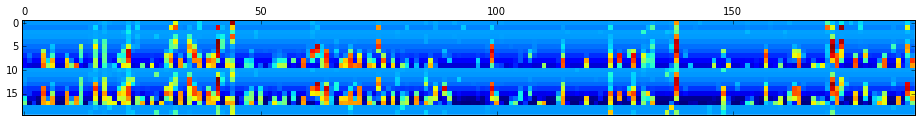

In [45]:
plt.matshow(vox_norm[:20,:], interpolation='None')

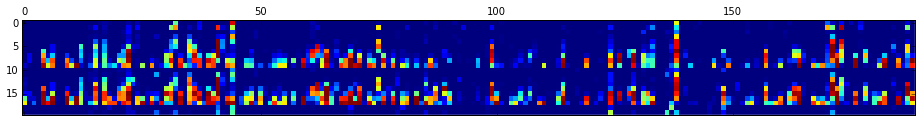

In [46]:
tmp = plt.matshow(non_norm[:20,:], interpolation='None')

In [53]:
vox_corr, vox_link = make_corr(vox_norm)

Let's quickly look at the correlation maps

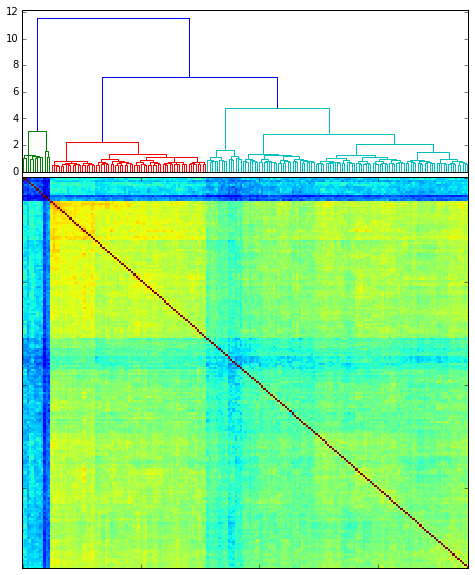

In [54]:
visu_net(non_corr, non_link)

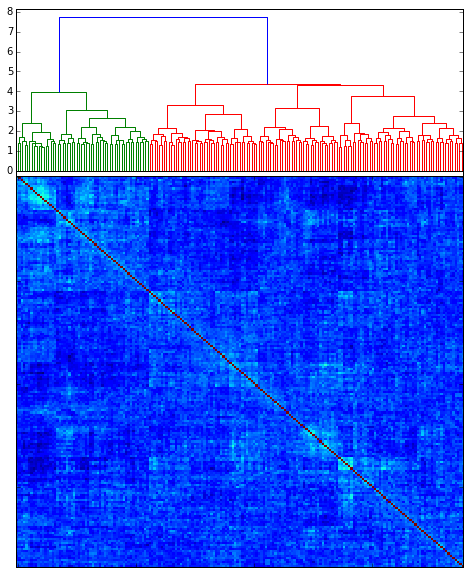

In [55]:
visu_net(vox_corr, vox_link)

Ok, the demeaned maps have a pretty strikingly different correlation map. Basically this translates to: most subjects don't have a 

In [153]:
# Make the partitions
non_part = make_part(non_link, 3)
vox_part = make_part(vox_link, 2)

In [154]:
def make_subtype(net_mat, part_sub):
    n_vox = net_mat.shape[0]
    n_files = net_mat.shape[1]
    subtypes = len(np.unique(part_sub))
    # Make the average of the subtypes
    sbt_avg = np.zeros((n_vox, subtypes))
    for idx in range(subtypes):
        sub_id = np.unique(part_sub)[idx]
        sbt_avg[..., idx] = np.mean(net_mat[...,part_sub==sub_id],1)
    return sbt_avg

In [155]:
non_subtype = make_subtype(non_norm, non_part)
vox_subtype = make_subtype(vox_norm, vox_part)

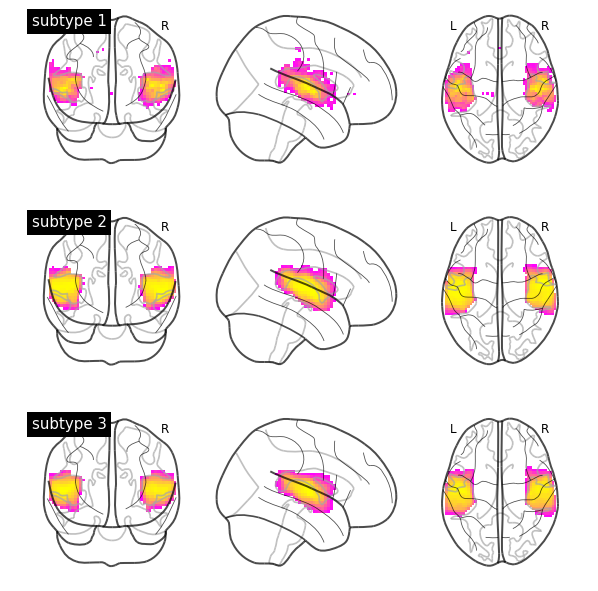

In [167]:
# Show the subtypes
visu_subtype(non_subtype, mask_path, figsz=(10,10))

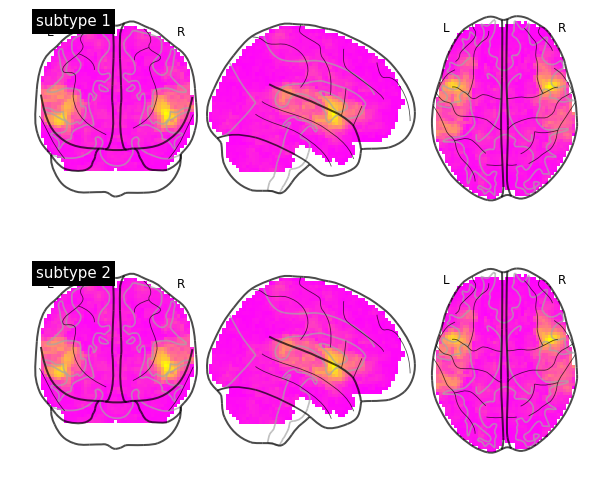

In [163]:
visu_subtype(vox_subtype, mask_path, threshold=0)

In [158]:
def prep_glm(pheno, net_mat, part_sub):
    """
    Prepare a glm
    """
    n_vox = net_mat.shape[0]
    n_files = net_mat.shape[1]
    subtypes = len(np.unique(part_sub))
    # Make the average of the subtypes
    sbt_avg = np.zeros((n_vox, subtypes))
    for idx in range(subtypes):
        sub_id = np.unique(part_sub)[idx]
        sbt_avg[..., idx] = np.mean(net_mat[...,part_sub==sub_id],1)
    
    # Generate the individual weights
    weights = np.zeros((n_files, subtypes))
    for s_id in range(subtypes):
        type_map = sbt_avg[:, s_id]
        weights[:, s_id] = np.array([np.corrcoef(type_map, net_mat[:,x])[0,1] for x in range(n_files)])
    
    # Generate the model matrix
    factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    
    return (weights, glm_pheno, sbt_avg)

In [159]:
def visu_weights(weights, part_sub, yrange=[0.3,1]):
    """
    Show the weights of each subtype
    """
    subtypes = len(np.unique(part_sub))
    # Show the weights by subtype
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
    for i, stp in enumerate(np.unique(part_sub)):
        ax = fig.add_subplot(gs[0,i])
        ax.set_ylim(yrange)
        ax.set_xticklabels([])
        # Take a subsample of the data, fitting the current subtype
        stp_data = weights[part_sub==stp,:]
        tmp = ax.violinplot(stp_data)
        ax.set_title('subjects subtype {}'.format(i+1))

In [160]:
# Get the weights and the GLM model matrix
(non_weights, glm_pheno, non_subtype_map) = prep_glm(clean_pheno, non_norm, non_part)
(vox_weights, glm_pheno, vox_subtype_map) = prep_glm(clean_pheno, vox_norm, vox_part)

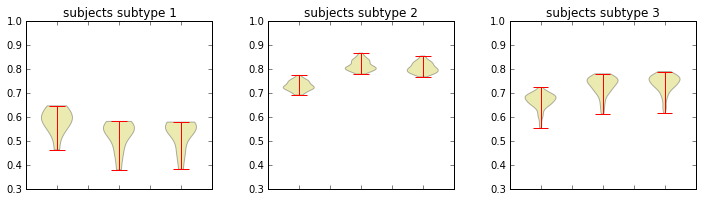

In [161]:
visu_weights(non_weights, non_part, yrange=[0.3,1])

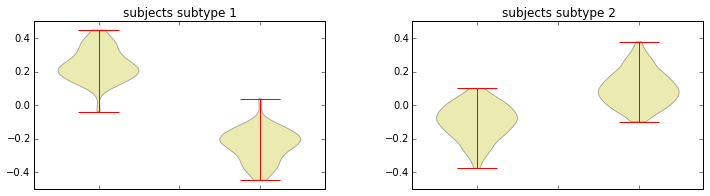

In [162]:
visu_weights(vox_weights, vox_part, yrange=[-0.5,0.5])

In [21]:
# Get the number of sites
n_sites = len(clean_pheno['SITE_ID'].unique())
# Prepare GLM contrasts
con_vec = np.zeros((2,glm_pheno.shape[1]))
# Diagnosis vs site
con_vec[0,1:n_sites] = 1
con_vec[0,n_sites] = -1*(n_sites-1)
# Diagnosis vs motion
con_vec[1,-1] = 1
con_vec[1,n_sites] = -1

In [22]:
con_vec

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.]])

In [23]:
# Run a GLM
glm_sbt1 = run_glm(weights, glm_pheno, subtype=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     9.352
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           7.18e-14
Time:                        16:22:18   Log-Likelihood:                 203.88
No. Observations:                 189   AIC:                            -381.8
Df Residuals:                     176   BIC:                            -339.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9727      0.035     28.077      

In [24]:
# Post Hoc Tests
glm_sbt1.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -1.0500      0.248     -4.233      0.000        -1.540    -0.560
c1            -0.9118      0.124     -7.367      0.000        -1.156    -0.667

In [25]:
glm_sbt2 = run_glm(weights, glm_pheno, subtype=1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     4.912
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           5.61e-07
Time:                        16:22:19   Log-Likelihood:                 321.49
No. Observations:                 189   AIC:                            -617.0
Df Residuals:                     176   BIC:                            -574.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.6391      0.019     34.371      

In [26]:
# Post Hoc Tests
glm_sbt2.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.3307      0.133     -2.483      0.014        -0.593    -0.068
c1            -0.2930      0.066     -4.410      0.000        -0.424    -0.162

In [27]:
glm_sbt3 = run_glm(weights, glm_pheno, subtype=2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     8.261
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           2.94e-12
Time:                        16:22:20   Log-Likelihood:                 220.68
No. Observations:                 189   AIC:                            -415.4
Df Residuals:                     176   BIC:                            -373.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.9329      0.032     29.431      

In [28]:
# Post Hoc Tests
glm_sbt3.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.8536      0.227     -3.761      0.000        -1.302    -0.406
c1            -0.8225      0.113     -7.263      0.000        -1.046    -0.599

In [29]:
glm_sbt4 = run_glm(weights, glm_pheno, subtype=3)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [381]:
# Post Hoc Tests
glm_sbt4.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.6085      0.224     -2.715      0.007        -1.051    -0.166
c1            -0.6553      0.112     -5.860      0.000        -0.876    -0.435